## 1. Importと定数定義

In [1]:
import torch
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
import wandb
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np

In [2]:
BATCH_SIZE = 256
LR = 1e-3
NUM_WORKERS = 4
EPOCHS = 50

## 2. Datasetsを読み込む

In [3]:
# 学習用データセット
train_datasets = datasets.MNIST(
    "data/",
    train=True,
    download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.RandomAutocontrast(),
        transforms.RandomApply(
            transforms=[
                transforms.ColorJitter(
                    brightness=0.2
                )
            ],
            p=0.3,
        ),
        transforms.Normalize(
            mean=[0],
            std=[1],
        ),
    ])
)
# 検証用データセット
val_datasets = datasets.MNIST(
    "data/",
    train=False,
    download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0],
            std=[1],
        ),
    ])
)

## 3. Modelの用意

In [4]:
class Model(nn.Module):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)        
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 256, kernel_size=7, stride=2, padding=2),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),            
        )
        self.pooling1 = nn.MaxPool2d((2, 2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),            
        )
        self.pooling2 = nn.AvgPool2d((2, 2))
        self.fc1 = nn.Linear(
            3 * 3 * 512,
            128
        )
        self.fc2 = nn.Linear(
            128,
            10
        )
        self.activation = nn.LogSoftmax(dim=1)
        
    def forward(self, x: torch.Tensor):
        x = self.layer1(x)
        x = self.pooling1(x)
        x = self.layer2(x) 
        x = self.pooling2(x)    
        x = x.view((-1, 3 * 3 * 512))
        x = self.fc1(x)
        x = self.fc2(x)
        out = self.activation(x)
        return out

### ネットワークの確認（任意）
今回MNISTは28×28pxなので同様の形状でネットワークに入力をして、出力が(BATCH_SIZE, 10)の形状のテンソルであることを確認する

In [5]:
input_image, input_label = val_datasets[40]
input_image.shape

torch.Size([1, 28, 28])

In [6]:
input_label = torch.tensor([input_label])

In [7]:
imgs = input_image.unsqueeze(dim=0)
labels = input_label.unsqueeze(dim=0)
model = Model()
outs = model(imgs)
outs

tensor([[-1.9140, -2.2339, -2.3009, -2.2515, -2.5398, -2.3550, -2.4176, -2.7520,
         -2.0022, -2.5481]], grad_fn=<LogSoftmaxBackward0>)

学習をしていない状態での予測結果を確認

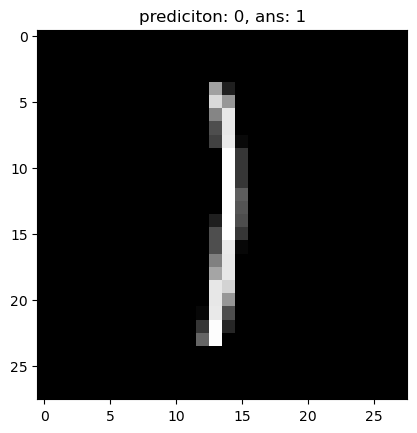

In [8]:
predict_label = torch.argmax(outs, dim=1)[0].item()
img = input_image.permute((1, 2, 0)).numpy()
plt.imshow(img, cmap="gray")
plt.title(f"prediciton: {predict_label}, ans: {input_label.item()}")
plt.show()

## 4.学習 & 検証

### 学習に必要な要素の準備

In [9]:
# デバイス
device = torch.device("cuda")

# 深層学習モデル
model = Model()
model = nn.DataParallel(model)
model = model.to(device)

# 損失関数
loss_fn = nn.NLLLoss() # nn.LogSoftmax + nn.NLLLoss == 交差クロスエントロピー

# 最適化関数
optimizer = optim.Adam(model.parameters(), lr=LR)

# 学習率スケジューラ
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer,
    T_max=EPOCHS,
    eta_min=LR * 0.01,
)

# データローダ
# 学習用
train_dataloader = DataLoader(
    train_datasets,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    shuffle=True,
)
# 検証用
val_dataloader = DataLoader(
    val_datasets,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    shuffle=False,
)

### 学習 & 検証

In [10]:
results = [
    {
        "train": {},
        "val": {}
    } for i in range(EPOCHS)
]

In [11]:
for epoch in tqdm(range(EPOCHS)):
    model.train()
    epoch_loss = 0
    correct_counts = 0
    for imgs, labels in tqdm(train_dataloader, leave=False):        
        optimizer.zero_grad()
        imgs = imgs.to(device)
        labels = labels.to(device)
        outs = model(imgs)
        loss = loss_fn(outs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()    
        preds = torch.argmax(outs, dim=1)
        correct_counts += (preds == labels).sum().item()
    lr_scheduler.step()
    acc = correct_counts / len(train_datasets)
    print(f"epoch: {epoch}, train loss: {epoch_loss:.3f}. train acc: {acc:.3f}")
    results[epoch]["train"]["acc"] = acc
    results[epoch]["train"]["loss"] = epoch_loss
    with torch.no_grad():
        model.eval()
        correct_counts = 0
        for imgs, labels in tqdm(val_dataloader, leave=False):
            imgs = imgs.to(device)
            labels = labels.to(device)
            outs = model(imgs)
            preds = torch.argmax(outs, dim=1)
            correct_counts += (preds == labels).sum().item()
        acc = correct_counts / len(val_datasets)
        print(f"epoch: {epoch}, val acc: {acc:.3f}")
        results[epoch]["val"]["acc"] = acc

  0%|          | 0/50 [00:00<?, ?it/s]

epoch: 0, train loss: 62.370. train acc: 0.929


  2%|▏         | 1/50 [00:21<17:17, 21.18s/it]

epoch: 0, val acc: 0.985


epoch: 1, train loss: 10.764. train acc: 0.986


  4%|▍         | 2/50 [00:28<10:17, 12.86s/it]

epoch: 1, val acc: 0.986


epoch: 2, train loss: 7.789. train acc: 0.990


  6%|▌         | 3/50 [00:34<07:50, 10.02s/it]

epoch: 2, val acc: 0.971


epoch: 3, train loss: 5.967. train acc: 0.992


  8%|▊         | 4/50 [00:41<06:48,  8.88s/it]

epoch: 3, val acc: 0.991


epoch: 4, train loss: 4.617. train acc: 0.993


 10%|█         | 5/50 [00:49<06:11,  8.26s/it]

epoch: 4, val acc: 0.985


epoch: 5, train loss: 4.079. train acc: 0.994


 12%|█▏        | 6/50 [00:55<05:36,  7.65s/it]

epoch: 5, val acc: 0.987


epoch: 6, train loss: 3.114. train acc: 0.996


 14%|█▍        | 7/50 [01:02<05:22,  7.50s/it]

epoch: 6, val acc: 0.991


epoch: 7, train loss: 2.271. train acc: 0.997


 16%|█▌        | 8/50 [01:09<05:07,  7.33s/it]

epoch: 7, val acc: 0.990


epoch: 8, train loss: 2.271. train acc: 0.997


 18%|█▊        | 9/50 [01:16<04:53,  7.16s/it]

epoch: 8, val acc: 0.987


epoch: 9, train loss: 2.976. train acc: 0.996


 20%|██        | 10/50 [01:23<04:45,  7.13s/it]

epoch: 9, val acc: 0.991


epoch: 10, train loss: 1.460. train acc: 0.998


 22%|██▏       | 11/50 [01:30<04:30,  6.95s/it]

epoch: 10, val acc: 0.991


epoch: 11, train loss: 1.413. train acc: 0.998


 24%|██▍       | 12/50 [01:37<04:25,  6.98s/it]

epoch: 11, val acc: 0.989


epoch: 12, train loss: 2.453. train acc: 0.997


 26%|██▌       | 13/50 [01:44<04:20,  7.03s/it]

epoch: 12, val acc: 0.979


epoch: 13, train loss: 2.548. train acc: 0.996


 28%|██▊       | 14/50 [01:50<04:07,  6.88s/it]

epoch: 13, val acc: 0.992


epoch: 14, train loss: 0.862. train acc: 0.999


 30%|███       | 15/50 [01:58<04:03,  6.95s/it]

epoch: 14, val acc: 0.991


epoch: 15, train loss: 0.683. train acc: 0.999


 32%|███▏      | 16/50 [02:04<03:55,  6.93s/it]

epoch: 15, val acc: 0.991


epoch: 16, train loss: 0.688. train acc: 0.999


 34%|███▍      | 17/50 [02:11<03:48,  6.92s/it]

epoch: 16, val acc: 0.992


epoch: 17, train loss: 0.521. train acc: 0.999


 36%|███▌      | 18/50 [02:18<03:43,  6.99s/it]

epoch: 17, val acc: 0.988


epoch: 18, train loss: 1.165. train acc: 0.998


 38%|███▊      | 19/50 [02:25<03:32,  6.87s/it]

epoch: 18, val acc: 0.990


epoch: 19, train loss: 3.034. train acc: 0.996


 40%|████      | 20/50 [02:32<03:28,  6.96s/it]

epoch: 19, val acc: 0.989


epoch: 20, train loss: 1.272. train acc: 0.998


 42%|████▏     | 21/50 [02:39<03:23,  7.01s/it]

epoch: 20, val acc: 0.992


epoch: 21, train loss: 0.123. train acc: 1.000


 44%|████▍     | 22/50 [02:46<03:13,  6.90s/it]

epoch: 21, val acc: 0.993


epoch: 22, train loss: 0.033. train acc: 1.000


 46%|████▌     | 23/50 [02:53<03:08,  6.97s/it]

epoch: 22, val acc: 0.994


epoch: 23, train loss: 0.012. train acc: 1.000


 48%|████▊     | 24/50 [03:00<02:59,  6.92s/it]

epoch: 23, val acc: 0.995


epoch: 24, train loss: 0.010. train acc: 1.000


 50%|█████     | 25/50 [03:07<02:52,  6.92s/it]

epoch: 24, val acc: 0.994


epoch: 25, train loss: 0.008. train acc: 1.000


 52%|█████▏    | 26/50 [03:14<02:48,  7.00s/it]

epoch: 25, val acc: 0.994


epoch: 26, train loss: 0.008. train acc: 1.000


 54%|█████▍    | 27/50 [03:21<02:37,  6.85s/it]

epoch: 26, val acc: 0.994


epoch: 27, train loss: 0.006. train acc: 1.000


 56%|█████▌    | 28/50 [03:28<02:32,  6.93s/it]

epoch: 27, val acc: 0.994


epoch: 28, train loss: 0.006. train acc: 1.000


 58%|█████▊    | 29/50 [03:35<02:25,  6.95s/it]

epoch: 28, val acc: 0.994


epoch: 29, train loss: 0.005. train acc: 1.000


 60%|██████    | 30/50 [03:41<02:17,  6.89s/it]

epoch: 29, val acc: 0.994


epoch: 30, train loss: 0.005. train acc: 1.000


 62%|██████▏   | 31/50 [03:49<02:12,  6.97s/it]

epoch: 30, val acc: 0.994


epoch: 31, train loss: 0.005. train acc: 1.000


 64%|██████▍   | 32/50 [03:55<02:03,  6.86s/it]

epoch: 31, val acc: 0.994


epoch: 32, train loss: 0.004. train acc: 1.000


 66%|██████▌   | 33/50 [04:02<01:57,  6.92s/it]

epoch: 32, val acc: 0.994


epoch: 33, train loss: 0.004. train acc: 1.000


 68%|██████▊   | 34/50 [04:09<01:51,  6.95s/it]

epoch: 33, val acc: 0.995


epoch: 34, train loss: 0.004. train acc: 1.000


 70%|███████   | 35/50 [04:16<01:42,  6.86s/it]

epoch: 34, val acc: 0.994


epoch: 35, train loss: 0.003. train acc: 1.000


 72%|███████▏  | 36/50 [04:23<01:37,  6.96s/it]

epoch: 35, val acc: 0.995


epoch: 36, train loss: 0.003. train acc: 1.000


 74%|███████▍  | 37/50 [04:30<01:30,  6.96s/it]

epoch: 36, val acc: 0.994


epoch: 37, train loss: 0.004. train acc: 1.000


 76%|███████▌  | 38/50 [04:37<01:23,  6.94s/it]

epoch: 37, val acc: 0.994


epoch: 38, train loss: 0.003. train acc: 1.000


 78%|███████▊  | 39/50 [04:44<01:16,  6.95s/it]

epoch: 38, val acc: 0.994


epoch: 39, train loss: 0.003. train acc: 1.000


 80%|████████  | 40/50 [04:50<01:08,  6.83s/it]

epoch: 39, val acc: 0.995


epoch: 40, train loss: 0.003. train acc: 1.000


 82%|████████▏ | 41/50 [04:58<01:02,  6.91s/it]

epoch: 40, val acc: 0.995


epoch: 41, train loss: 0.003. train acc: 1.000


 84%|████████▍ | 42/50 [05:05<00:55,  6.95s/it]

epoch: 41, val acc: 0.994


epoch: 42, train loss: 0.002. train acc: 1.000


 86%|████████▌ | 43/50 [05:11<00:47,  6.82s/it]

epoch: 42, val acc: 0.994


epoch: 43, train loss: 0.002. train acc: 1.000


 88%|████████▊ | 44/50 [05:18<00:41,  6.92s/it]

epoch: 43, val acc: 0.994


epoch: 44, train loss: 0.002. train acc: 1.000


 90%|█████████ | 45/50 [05:25<00:34,  6.89s/it]

epoch: 44, val acc: 0.995


epoch: 45, train loss: 0.002. train acc: 1.000


 92%|█████████▏| 46/50 [05:32<00:27,  6.88s/it]

epoch: 45, val acc: 0.994


epoch: 46, train loss: 0.002. train acc: 1.000


 94%|█████████▍| 47/50 [05:39<00:20,  6.95s/it]

epoch: 46, val acc: 0.994


epoch: 47, train loss: 0.002. train acc: 1.000


 96%|█████████▌| 48/50 [05:45<00:13,  6.80s/it]

epoch: 47, val acc: 0.995


epoch: 48, train loss: 0.002. train acc: 1.000


 98%|█████████▊| 49/50 [05:53<00:06,  6.90s/it]

epoch: 48, val acc: 0.994


epoch: 49, train loss: 0.002. train acc: 1.000


100%|██████████| 50/50 [06:00<00:00,  7.20s/it]


epoch: 49, val acc: 0.995


# 5.可視化

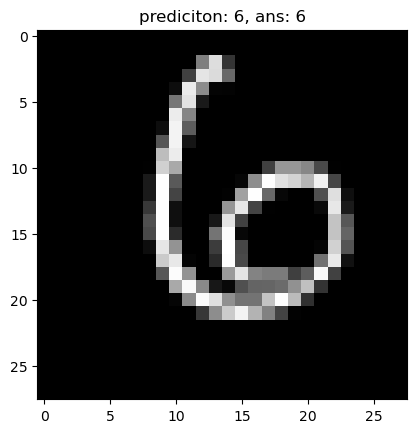

In [12]:
img, label = val_datasets[100]
outs = model(img.unsqueeze(dim=0))

predict_label = torch.argmax(outs, dim=1)[0].item()
img = img.permute((1, 2, 0)).numpy()
plt.imshow(img, cmap="gray")
plt.title(f"prediciton: {predict_label}, ans: {label}")
plt.show()

In [13]:
train_acc = []
train_loss = []
val_acc = []
for result in results:
    train_acc.append(result["train"]["acc"])
    train_loss.append(result["train"]["loss"])
    val_acc.append(result["val"]["acc"])

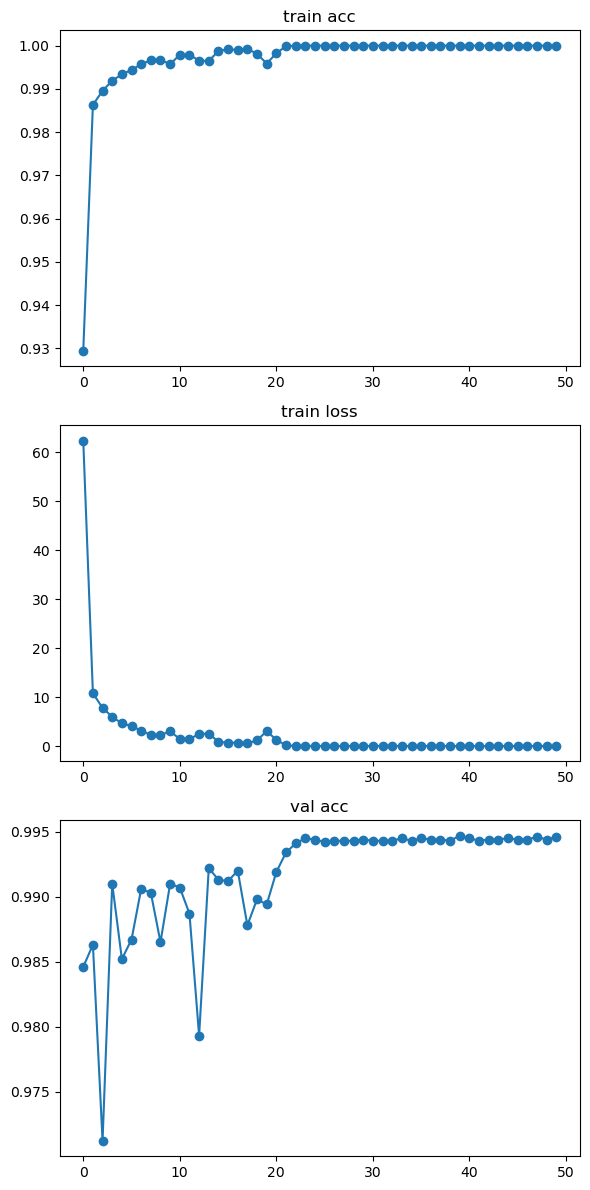

In [14]:
x = np.array(range(EPOCHS))
fig, axes = plt.subplots(3, 1, figsize=(6, 12))

axes[0].plot(x, train_acc, marker="o")
axes[0].set_title("train acc")
axes[1].plot(x, train_loss, marker="o")
axes[1].set_title("train loss")
axes[2].plot(x, val_acc, marker="o")
axes[2].set_title("val acc")
fig.tight_layout()
fig.show()